In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import time
import tdmclient
import tdmclient.notebook
import threading

import camera as cam
import vision_utils as utils
import Global_tomerge as global_nav
import local_nav as local_nav

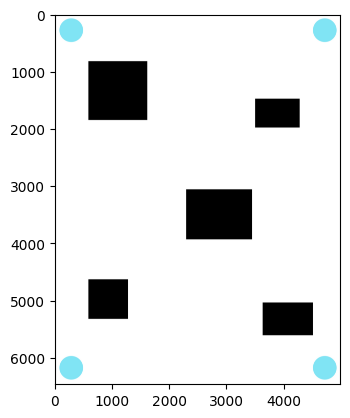

------


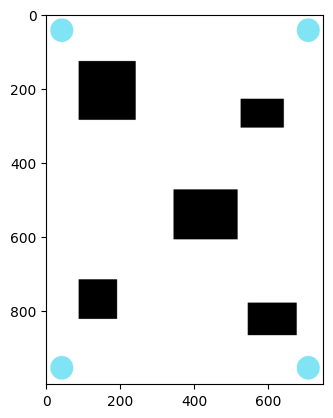

In [2]:
# Load the image
image = cv2.imread('maps/map_mobile_robotics_final3.jpeg')

# Inverse red and blue
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()
print("------")
#Resize this image to 1mx1m
image = cv2.resize(image, (750, 1000))

# Convert the image from BGR to RGB
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image)
plt.show()

## Preprocessing

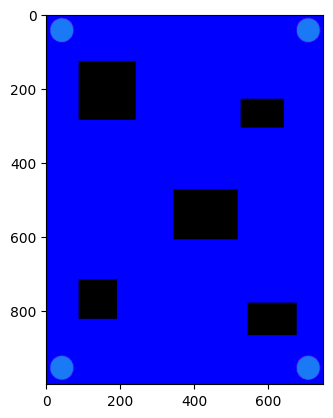

In [3]:
# Convert the image to HSV
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Display the image
plt.imshow(hsv)
plt.show()

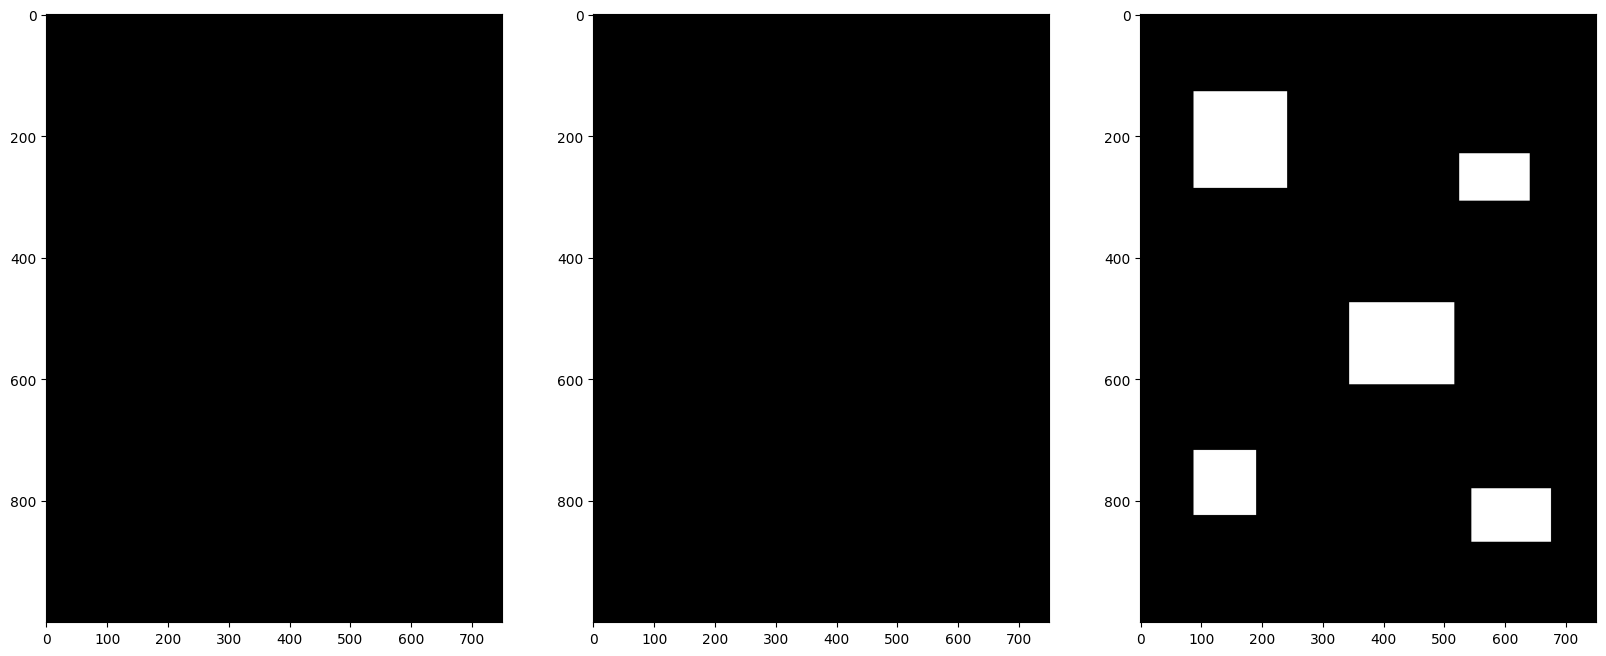

In [4]:
# Define color ranges for green squares in 
green_lower = np.array([35, 100, 100])
green_upper = np.array([85, 255, 255])
green_mask = cv2.inRange(hsv, green_lower, green_upper)

# Define color ranges for light blue squares in hsv
blue_lower = np.array([85, 80, 80])
blue_upper = np.array([135, 255, 255])
blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)


# Define color ranges for black squares or rectangles
black_lower = np.array([0, 0, 0])
black_upper = np.array([180, 255, 30])
black_mask = cv2.inRange(hsv, black_lower, black_upper)

#display the 3 masks
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(green_mask, cmap="gray")
plt.subplot(132)
plt.imshow(blue_mask, cmap="gray")
plt.subplot(133)
plt.imshow(black_mask, cmap="gray")
plt.show()


In [ ]:
# Find contours for each colour
green_contours, _ = cv2.findContours(green_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
blue_contours, _ = cv2.findContours(blue_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
black_contours, _ = cv2.findContours(black_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
black_contours = black_contours[2:] # Exclude the map contour

# Display the variables
print("Green contours: ", len(green_contours))
print("Blue contours: ", len(blue_contours))
print("Black contours: ", len(black_contours))

Green contours:  1
Blue contours:  1
Black contours:  5


In [ ]:
# Draw contours on the original image
#Code for orange

cv2.drawContours(image, black_contours, -1, (0, 255, 255), 3);  # Red       color for   black   squares
cv2.drawContours(image, green_contours, -1, (0, 165, 255), 3);  # Orange    color for   green   squares
cv2.drawContours(image, blue_contours, -1, (255, 0, 0), 3);     # Yellow    color for   blue    squares


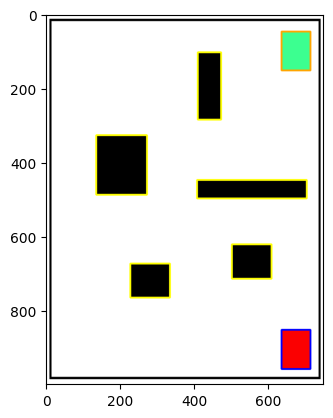

In [ ]:
# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

# Approximate contours to polygons and detect quadrilaterals for each color
for color_contours in [blue_contours, green_contours, black_contours]:
   for cnt in color_contours:
       rectangle = cv2.minAreaRect(cnt)
       (center_x, center_y), (width, height), angle = rectangle
       if abs(width - height) < 400:
           print(f'Quadrilateral found at coordinates: {center_x}, {center_y}')


In [ ]:
for cnt in blue_contours:
 approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True)
 if len(approx) == 4:
     x, y, w, h = cv2.boundingRect(cnt)
     print(f'Blue square found at coordinates: {x}, {y}')

for cnt in green_contours:
 approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True)
 if len(approx) == 4:
     x, y, w, h = cv2.boundingRect(cnt)
     print(f'Green square found at coordinates: {x}, {y}')

for cnt in black_contours:
 approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True)
 if len(approx) == 4:
     x, y, w, h = cv2.boundingRect(cnt)
     print(f'Black square found at coordinates: {x}, {y}')


Blue square found at coordinates: 635, 853
Green square found at coordinates: 635, 47
Black square found at coordinates: 227, 674
Black square found at coordinates: 501, 622
Black square found at coordinates: 407, 448
Black square found at coordinates: 135, 327
Black square found at coordinates: 409, 103


In [ ]:
def find_coordinates(contours, color):
    coordinates = {}
    obstacle_counter = 1
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True)
        if len(approx) == 4:
            rectangle = cv2.minAreaRect(cnt)
            box = cv2.boxPoints(rectangle)
            box = np.intp(box)  
            
            # Give the coordinates of the rectangles in the desired order
            new_order = np.array([box[1], box[2], box[3], box[0]])
            box = new_order

            if color == 'Black':
                rectangle_corners = []
                for point in box:
                    corner = (point[0], point[1])
                    rectangle_corners.append(corner)
                coordinates[f"Obstacle_{obstacle_counter}"] = rectangle_corners
                obstacle_counter += 1
            elif color in ['Green', 'Blue']:
                M = cv2.moments(cnt)
                if M["m00"] != 0:
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    if color == 'Green':
                        coordinates["Goal"] = (cX, cY)
                    else:
                        coordinates["Position"] = (cX, cY)
    return coordinates



In [ ]:
# Define the coordinates of the map
map_coordinates = [(0, 0), (0, 1000), (1000, 1000), (1000, 0)]

# Blue squares
blue_coordinates = []
blue_coordinates = find_coordinates(blue_contours, 'Blue')

# Green squares
green_coordinates = []
green_coordinates = find_coordinates(green_contours, 'Green')

# Black rectangles
black_coordinates = []
black_coordinates = find_coordinates(black_contours, 'Black')

#Alternatively, if you want to ensure all the boxes are sorted in a specific manner, you might consider calculating their centroids and using these for sorting:

def sort_by_centroid(coordinates):
    centroids = [np.mean(box, axis=0) for box in coordinates]
    coordinates.sort(key=lambda box: np.mean(box, axis=0)[0])  # Sort by x-coordinate of centroid
    return coordinates

#blue_coordinates = sort_by_centroid(blue_coordinates)
#green_coordinates = sort_by_centroid(green_coordinates)
#black_coordinates = sort_by_centroid(black_coordinates)

# Display the coordinates and type of variables 
print("Blue coordinates: ", blue_coordinates)
print("Green coordinates: ", green_coordinates)
print("Black coordinates: ", black_coordinates)

Blue coordinates:  {'Position': (674, 906)}
Green coordinates:  {'Goal': (674, 99)}
Black coordinates:  {'Obstacle_1': [(227, 673), (334, 673), (334, 765), (227, 765)], 'Obstacle_2': [(501, 621), (608, 621), (608, 714), (501, 714)], 'Obstacle_3': [(703, 448), (703, 498), (407, 498), (407, 448)], 'Obstacle_4': [(272, 327), (272, 488), (135, 488), (135, 327)], 'Obstacle_5': [(472, 103), (472, 285), (409, 285), (409, 103)]}


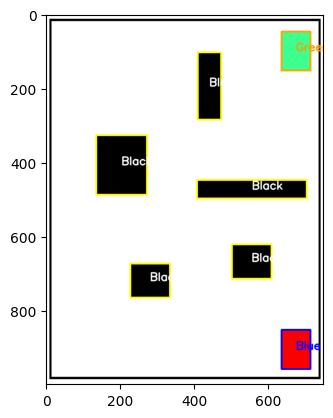

In [ ]:
#Next to each square or rectangle, we will write the label of the square or rectangle inside the square or rectangle
def write_colour_label(image, coordinates, color):
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    color_text_map = {
        'Black': (255, 255, 255),   # White text for Black contour
        'Green': (0, 155, 255),     # Orange text for Green contour 
        'Blue' : (255, 0, 0),       # Yellow text for Blue contour
    }

    text_color = color_text_map.get(color, (255, 255, 255))  # Default to white if no mapping found

    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True)
        if len(approx) == 4:
            rectangle = cv2.minAreaRect(cnt)
            box = cv2.boxPoints(rectangle)
            box = np.int0(box)
            if color == 'Black':
                coordinates.append(box)
            elif color in ['Green', 'Blue']:
                M = cv2.moments(cnt)
                if M["m00"] != 0:
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    coordinates.append([(cX, cY)])

    return image


# Write text for blue squares
image = write_colour_label(image, blue_coordinates, 'Blue')

# Write text for green squares
image = write_colour_label(image, green_coordinates, 'Green')

# Write text for black rectangles
image = write_colour_label(image, black_coordinates, 'Black')

# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


In [ ]:
# Convert lists to tuples after sorting
blue_coordinates = [tuple(coord) for coord in blue_coordinates]
green_coordinates = [tuple(coord) for coord in green_coordinates]
black_coordinates = [tuple(coord) for coord in black_coordinates]

Measurement noise matrix : x position and y position of the thymio is there is 

## Displaying the video

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import camera as cam
import vision_utils as utils
import threading

In [ ]:

def camera_thread():
    global end,start,obstacles
    try:
        cap = cv2.VideoCapture(0)

        if not cap.isOpened():
            print("Error opening video stream or file")
            return
        mode = 'all'
        color_type = 'RGB'

        thresold  = [cam.COLOR_THREASHOLD,cam.SATURATION_THRESHOLD,cam.BRIGHTNESS_THRESHOLD]

        cv2.namedWindow("Camera Vision", cv2.WINDOW_NORMAL)
        cv2.createTrackbar("Color Threshold", "Camera Vision", thresold[0], 200, lambda x: utils.on_trackbar(x,thresold))
        cv2.createTrackbar("Saturation Threshold", "Camera Vision", thresold[1], 200, lambda x: utils.on_trackbar(x,thresold))
        cv2.createTrackbar("Brightness Threshold", "Camera Vision", thresold[2], 200, lambda x: utils.on_trackbar(x,thresold))
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame = cam.zoom_frame(frame,zoom_factor=2)
            frame, end, start, obstacles = cam.obstacle_detection(frame,mode,color_type,thresold[0],thresold[1],thresold[2])

            cv2.imshow("Camera Vision", frame)

            key = cv2.waitKey(25) & 0xFF
            if key == 27:  # ESC key to exit
                break
            elif key == ord('1'):  # '1' key to switch to blue mode
                mode = 'blue'
            elif key == ord('2'):  # '2' key to switch to green mode
                mode = 'green'
            elif key == ord('3'):  # '3' key to switch to black mode
                mode = 'black'
            elif key == ord('4'):  # '4' key to switch to black mode
                mode = 'all'
            elif key == ord('5'):  # '5' key to switch to RGB mode
                color_type = 'RGB'
            elif key == ord('6'):  # '6' key to switch to BGR mode
                color_type = 'BGR'

            time.sleep(0.01)

    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        cap.release()
        cv2.destroyAllWindows()
        print("Done displaying the video")



In [ ]:
cam_thread= threading.Thread(target=camera_thread)

In [ ]:
cam_thread.start()

Done displaying the video


## Filtering

In [ ]:
import matplotlib.colors as colors
def color_to_hsv(color):
    color = color/255
    hsv = colors.rgb_to_hsv(color)
    hsv[0][0] = hsv[0][0]*360
    hsv[0][1] = hsv[0][1]*255
    hsv[0][2] = hsv[0][2]*255
    return hsv.astype(np.uint8)

GREEN_RGB = np.array([[0, 255, 0]], dtype=np.uint8)
GREEN_HSV = color_to_hsv(GREEN_RGB)
print("Green in RGB: ", GREEN_RGB)
print("Green in HSV: ", GREEN_HSV)


Green in RGB:  [[  0 255   0]]
Green in HSV:  [[120 255 255]]


In [ ]:
def hsv_range(base_color, color_threashold,saturation_threshold, brightness_threshold):
    # Convert base color to HSV
    hsv_base_color = color_to_hsv(base_color)
    # Extract hue, saturation and value from base color
    h, s, v = hsv_base_color[0, 0, :]
    
    # Define lower and upper bounds for hue
    lower_hue = h - color_threashold
    upper_hue = h + color_threashold
    if lower_hue < 0:
        lower_hue = 360 + lower_hue
    if upper_hue > 360:
        upper_hue = upper_hue - 360
    
    lower = np.array([lower_hue, saturation_threshold, brightness_threshold], dtype=np.uint8)
    upper = np.array([upper_hue, 255, 255], dtype=np.uint8)

    return lower, upper

print(hsv_range(GREEN_RGB, 0, 50, 50))

(array([60, 50, 50], dtype=uint8), array([ 60, 255, 255], dtype=uint8))
